In [35]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import Table
import matplotlib.pyplot as plt 
import numpy as np
from astroML.stats import binned_statistic_2d
%matplotlib inline

Read first the SDSS Bramich et al. HLC catalog

In [2]:
datafile = 'HLC.RA_00_to_01.fits'
HLCtable = Table.read(datafile, format='fits')
# df = table.to_pandas()   # Cannot convert a table with multi-dimensional columns to a pandas DataFrame

In [3]:
raHLC = HLCtable['RA_MEAN']
decHLC = HLCtable['DEC_MEAN']
np.size(raHLC)

446842

And now read the NSC catalog

In [4]:
NSCdatafile = 'NSC_stripe82_DecPositive.csv'
NSCtable = Table.read(NSCdatafile, format='csv')
raNSC = NSCtable['ra']
decNSC = NSCtable['dec']
np.size(raNSC)

3692781

Match HLC to NSC, since here NSC is much larger 

In [5]:
HLCcoords = SkyCoord(ra = raHLC*u.degree, dec= decHLC*u.degree) 
NSCcoords = SkyCoord(ra = raNSC*u.degree, dec= decNSC*u.degree) 

# this is looking for NSC matches to HLC sources (indices are into NSC catalog) 
# makes sense in this case since the NSC catalog is bigger than the HLC catalog
idx, d2d, d3d = HLCcoords.match_to_catalog_sky(NSCcoords)  

In [6]:
# object separation is an object with units, add it as a column 
# so that one can select based on separation to the nearest matching object
HLC_NSC = hstack([HLCtable, NSCtable[idx]], table_names = ['HLC', 'NSC'])
HLC_NSC['sep_2d_arcsec'] = d2d.arcsec
# since it's matching HLC to NSC, the resulting catalog has the same length as HLC 

Select good matches

In [8]:
# declare good match to be within a certain distance limit 
# there is no built-in boundary - match_to_catalog_sky() finds nearest matches

# HLC sources that have a good DL match 
maxRadiusGoodMatch = 0.5   # in arcsec
flag = (HLC_NSC['sep_2d_arcsec'] < maxRadiusGoodMatch)   
HLCmatches = HLC_NSC[flag]
print(len(HLCmatches))
dra = 3600*(HLCmatches['RA_MEAN'] - HLCmatches['ra']) 
ddec = 3600*(HLCmatches['DEC_MEAN'] - HLCmatches['dec'])  

213541


Make a few basic QA plots

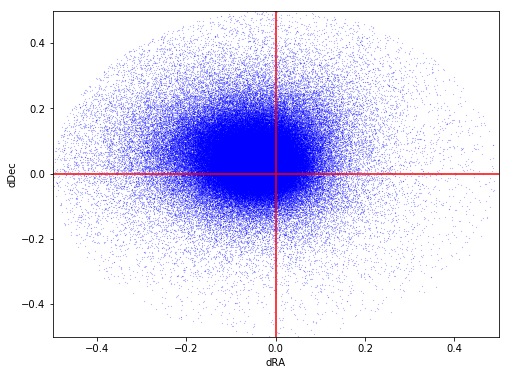

-0.0492771284513
0.0947791874894
0.0419448518393
0.0918357713931
-0.499308381578
0.48990097687


In [13]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(dra, ddec, s=0.01, c='blue')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_xlabel('dRA')
ax.set_ylabel('dDec')
ax.plot([-0.5,0.5], [0.0, 0.0], '-k', c='red')
ax.plot([0,0], [-0.5, 0.5], '-k', c='red')
plt.show()
print np.median(dra)
print np.std(dra)
print np.median(ddec)
print np.std(ddec)
print np.min(dra)
print np.max(dra)

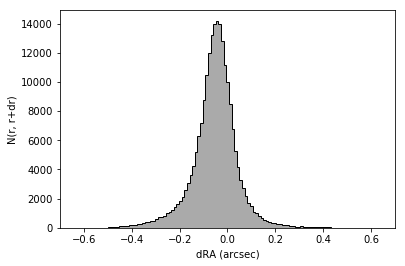

-0.0492771284513


In [15]:
from astroML.plotting import hist
ax = plt.axes()
hist(dra, bins='knuth', ax=ax, histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('dRA (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-0.7, 0.7)
plt.show()
print np.median(dra)

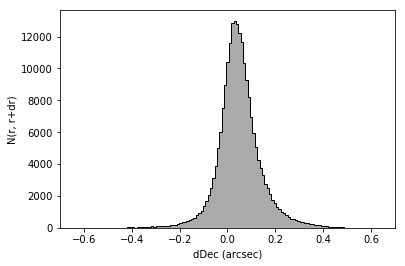

0.0419448518393


In [16]:
from astroML.plotting import hist
ax = plt.axes()
hist(ddec, bins='knuth', ax=ax, histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('dDec (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-0.7, 0.7)
plt.show()
print np.median(ddec)

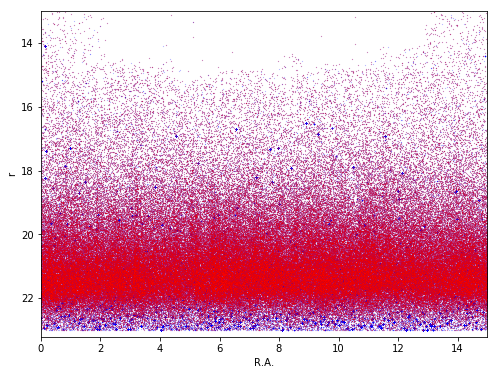

In [18]:
ra = HLCmatches['ra']  
raAll = HLC_NSC['ra']  
r = HLCmatches['rmag']
rAll = HLC_NSC['rmag']
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raAll, rAll, s=0.01, c='blue')
ax.scatter(ra, r, s=0.01, c='red')
ax.set_xlim(0,15)
ax.set_ylim(23.2,13)
ax.set_xlabel('R.A.')
ax.set_ylabel('r')

In [29]:
# HLC proper motions
HLCpmRA = 1000*HLCmatches['RA_PM']
HLCpmRAerr = 1000*HLCmatches['RA_PM_ERR']
HLCpmDec = 1000*HLCmatches['DEC_PM']
HLCpmDecerr = 1000*HLCmatches['DEC_PM_ERR']
# NSC proper motions 
NSCpmRA = HLCmatches['pmra']
NSCpmRAerr = HLCmatches['pmraerr']
NSCpmDec = HLCmatches['pmdec']
NSCpmDecerr = HLCmatches['pmdecerr']

1.50016653538
-4.14237507192


In [47]:
HLCpmRAerrB = HLCpmRAerr[r<20]
NSCpmRAerrB = NSCpmRAerr[r<20]
print np.median(HLCpmRAerrB)
print np.median(NSCpmRAerrB)

3.47310876846
5.62180196977


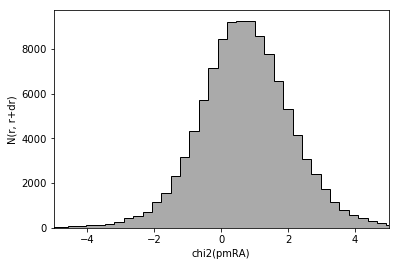

1.4459863719


In [76]:
rMax = 21
HLCpmRAB = HLCpmRA[r<rMax]
NSCpmRAB = NSCpmRA[r<rMax]
HLCpmRAerrB = HLCpmRAerr[r<rMax]
NSCpmRAerrB = NSCpmRAerr[r<rMax]
chi2 = (HLCpmRAB-NSCpmRAB)/np.sqrt(HLCpmRAerrB**2+NSCpmRAerrB**2)
chi2ok = chi2[abs(chi2)<10]
ax = plt.axes()
hist(chi2ok, bins='knuth', ax=ax, histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('chi2(pmRA)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-5, 5)
plt.show()
print np.std(chi2ok)

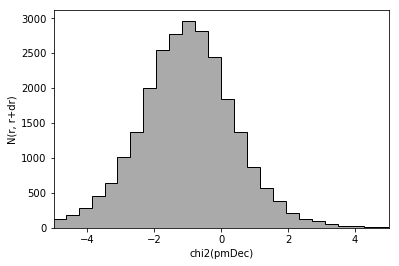

1.56380343117


In [77]:
rMax = 19
HLCpmDecB = HLCpmDec[r<rMax]
NSCpmDecB = NSCpmDec[r<rMax]
HLCpmDecerrB = HLCpmDecerr[r<rMax]
NSCpmDecerrB = NSCpmDecerr[r<rMax]
chi2 = (HLCpmDecB-NSCpmDecB)/np.sqrt(HLCpmDecerrB**2+NSCpmDecerrB**2)
chi2ok = chi2[abs(chi2)<20]
ax = plt.axes()
hist(chi2ok, bins='knuth', ax=ax, histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_xlabel('chi2(pmDec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-5, 5)
plt.show()
print np.std(chi2ok)

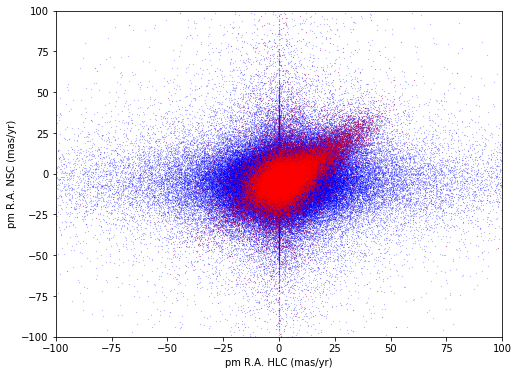

In [46]:
HLCpmRAB = HLCpmRA[r<20]
NSCpmRAB = NSCpmRA[r<20]
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(HLCpmRA, NSCpmRA, s=0.01, c='blue')
ax.scatter(HLCpmRAB, NSCpmRAB, s=0.01, c='red')
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.set_xlabel('pm R.A. HLC (mas/yr)')
ax.set_ylabel('pm R.A. NSC (mas/yr)')

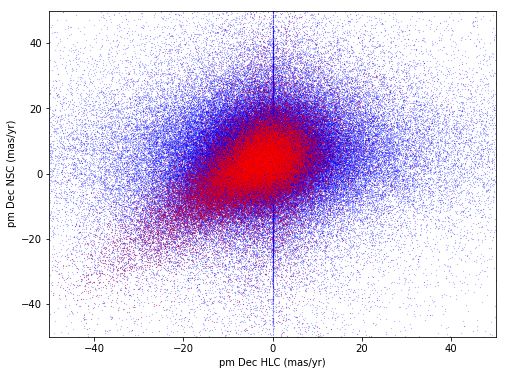

In [45]:
HLCpmDecB = HLCpmDec[r<20]
NSCpmDecB = NSCpmDec[r<20]
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(HLCpmDec, NSCpmDec, s=0.01, c='blue')
ax.scatter(HLCpmDecB, NSCpmDecB, s=0.01, c='red')
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.set_xlabel('pm Dec HLC (mas/yr)')
ax.set_ylabel('pm Dec NSC (mas/yr)')

In [54]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i], medianBin[i], sigGBin[i] = 0
        
    if (verbose):
        print('median:', np.median(medianBin[Npts>0]))

    return xBin, nPts, medianBin, sigGbin

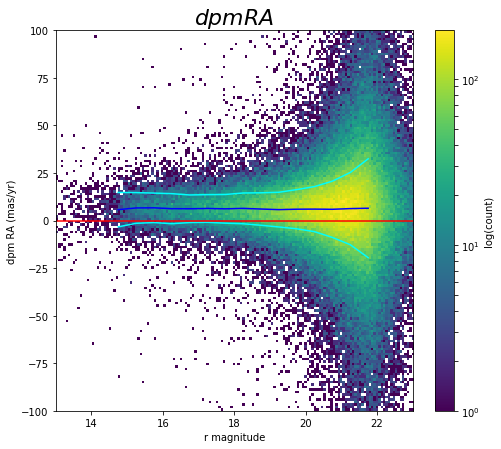

In [71]:
multicolor = plt.cm.rainbow
fig, axes = plt.subplots(1, 1, figsize=(8, 7))
from matplotlib.colors import LogNorm

dPMra = HLCpmRA - NSCpmRA
rOK = r[np.abs(dPMra)<1000]
dPMraOK = dPMra[np.abs(dPMra)<1000]
h = axes.hist2d(rOK, dPMraOK, bins=150, norm=LogNorm(), range=[[13,23], [-100, 100]])
axes.set_title('$dpmRA$', fontsize=22)
axes.set_xlabel(r"r magnitude")
axes.set_ylabel(r"dpm RA (mas/yr)")
plt.colorbar(h[3], ax=axes, label=r"log(count)")
 
xBinM, nPtsM, medianBinM, sigGbinM = fitMedians(rOK, dPMraOK, 14.5, 22.0, 15, 0)
rmsBin = np.sqrt(nPtsM) / np.sqrt(np.pi/2) * sigGbinM
rmsP = medianBinM + rmsBin
rmsM = medianBinM - rmsBin
plt.plot(xBinM, rmsP, c='cyan')
plt.plot(xBinM, rmsM, c='cyan')
plt.plot(xBinM, medianBinM, c='blue')
axes.plot([0, 100], [0, 0], c='red')

plt.show()

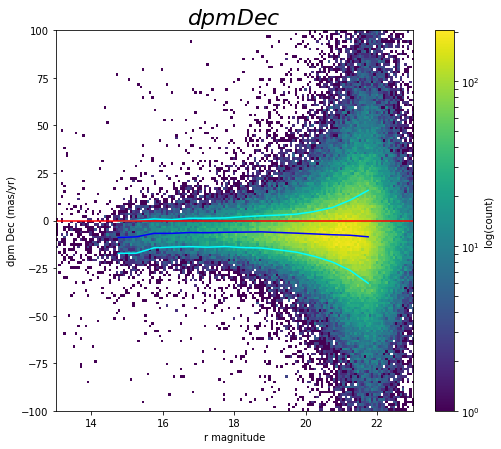

In [73]:
multicolor = plt.cm.rainbow
fig, axes = plt.subplots(1, 1, figsize=(8, 7))
from matplotlib.colors import LogNorm

dPMdec = HLCpmDec - NSCpmDec
rOK = r[np.abs(dPMdec)<1000]
dPMdecOK = dPMdec[np.abs(dPMdec)<1000]
h = axes.hist2d(rOK, dPMdecOK, bins=150, norm=LogNorm(), range=[[13,23], [-100, 100]])
axes.set_title('$dpmDec$', fontsize=22)
axes.set_xlabel(r"r magnitude")
axes.set_ylabel(r"dpm Dec (mas/yr)")
plt.colorbar(h[3], ax=axes, label=r"log(count)")

xBinM, nPtsM, medianBinM, sigGbinM = fitMedians(rOK, dPMdecOK, 14.5, 22.0, 15, 0)
rmsBin = np.sqrt(nPtsM) / np.sqrt(np.pi/2) * sigGbinM
rmsP = medianBinM + rmsBin
rmsM = medianBinM - rmsBin
plt.plot(xBinM, rmsP, c='cyan')
plt.plot(xBinM, rmsM, c='cyan')
plt.plot(xBinM, medianBinM, c='blue')
axes.plot([0, 100], [0, 0], c='red')

plt.show()